# Milestone 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import utils.preprocessing as pp


## Data Acquisition

We are using historical [Two-Line Element](https://en.wikipedia.org/wiki/Two-line_element_set) sets and satellite catalog information from the [space-track.org](https://www.space-track.org/) API. Space-track offers both a current state catalog as well as the ability to query historical state catalogs.

For our project, we want to go back two years and pull the state record for the 1st and 15th of each month. Due to orbital perturbations, tactical space operations, and the nature of the TLE, state encodings for even stable objects will change over time. This makes having multiple state representations for the same object useful and prevents duplicate information. As a step zero, we pulled our snapshots from the space-track API and saved them as .zip files. We also pulled both the current satellite catalog as well as the decayed satellite catalog (and saved these as .zip files as well).

**To see the process described above, visit the [DataAcquisition.ipynb](https://github.com/tedinspace/space-object-identification/blob/main/src/DataAcquisition.ipynb) notebook.**


In [3]:
satCat_current = pd.DataFrame(pp.loadUnprocessedSatCat_current("../data/satcat.zip")).set_index("NORAD_CAT_ID")
satCat_decayed = pd.DataFrame(pp.loadUnprocessedSatCat_decayed("../data/satcat.zip")).set_index("NORAD_CAT_ID")
snapshot_states = pp.loadSeveralYearsOfUnprocessedStates(["../data/snapshots_2023.zip","../data/snapshots_2024_p1.zip","../data/snapshots_2024_p2.zip","../data/snapshots_2025.zip"])

## Data Description

Now that we have the snapshots of our historical states saved locally, we can create a pandas dataframe that contains the following merged information:

1. State information - in TLE form.
2. Satellite catalog (satcat) information - descriptive information about a satellite.
3. Calculated additional values - semi-major axis, apogee, perigee, and orbital regime need to be calculated using state information.


#### State Data: Two-Line Element Sets


[AEHF 4](https://www.n2yo.com/satellite/?s=43651)

<table>
<tbody>
    <tr>
        <td>Line 1</td>
        <td>1 43651U 18079A   25074.81403196 -.00000276  00000-0  00000-0 0  9990</td>
    </tr>
     <tr>
        <td>Line 2</td>
        <td>2 43651   1.5535 338.6932 0052106   7.7813  52.6795  1.00274975 23705</td>
    </tr>
</tbody>
</table>


<h4>Line 1</h4>

<table>
  <tbody>
     <tr> 
      <td>Relevant Info (Y/M/N)</td>
      <td>Value</td>
      <td>Name</td>
      <td>Description</td>
    </tr>
    <tr> 
      <td style="background-color:red;">N</td>
      <td>1</td>
      <td>Line Number</td>
      <td>Identifies what line you are reading</td>
    </tr>
    <tr> 
      <td style="background-color:green;">Y</td>
      <td>43651</td>
      <td>Catalog Number</td>
      <td>A unique identifier for the satellite</td>
    </tr>
    <tr> 
      <td style="background-color:red;">N</td>
      <td>U</td>
      <td>Classification</td>
      <td>Indicates the object is unclassified</td>
    </tr>
    <tr> 
      <td style="background-color:red;">N</td>
      <td>18079A</td>
      <td>International Designator</td>
      <td>A unique identifier for the launch (year, launch number, piece of the launch)</td>
    </tr>
    <tr> 
      <td style="background-color:red;">N</td>
      <td>25074.81403196</td>
      <td>Epoch Time</td>
      <td>The time when the TLE was valid (in YYDDD.DDDDDDDD format); probably won't use as we want our model to be time independent</td>
    </tr>
    <tr> 
      <td style="background-color:orange;">M</td>
      <td>-0.00000276</td>
      <td>First Derivative of the Mean Motion</td>
      <td>Rate of change of the satellite’s orbit</td>
    </tr>
    <tr> 
      <td style="background-color:orange;">M</td>
      <td>00000-0</td>
      <td>Second Derivative of Mean Motion (decimal point assumed)</td>
      <td>Shows the acceleration of the satellite's orbit, which is usually close to zero</td>
    </tr>
    <tr> 
      <td style="background-color:orange;">M</td>
      <td>00000-0</td>
      <td>B-STAR </td>
      <td>The drag term, or radiation pressure coefficient (decimal point assumed)</td>
    </tr>
    <tr> 
      <td style="background-color:red;">N</td>
      <td>0</td>
      <td>Ephem Type</td>
      <td>Always zero</td>
    </tr>
    <tr> 
      <td style="background-color:red;">N</td>
      <td>999</td>
      <td>ElSet Number</td>
      <td>Element set number. Incremented when a new TLE is generated for this object</td>
    </tr>
    <tr> 
      <td style="background-color:red;">N</td>
      <td>0</td>
      <td>CheckSum</td>
      <td>Checksum (modulo 10)</td>
    </tr>
  </tbody>
</table>


<h4>Line 2</h4>

<table>
  <tbody>
     <tr> 
      <td>Relevant Info (Y/M/N)</td>
      <td>Value</td>
      <td>Name</td>
      <td>Description</td>
    </tr>
    <tr> 
      <td style="background-color:red;">N</td>
      <td>2</td>
      <td>Line Number</td>
      <td>Identifies the second line of the TLE</td>
    </tr>
    <tr> 
      <td style="background-color:red;">N</td>
      <td>43651</td>
      <td>Catalog Number</td>
      <td>The same unique identifier as in Line 1</td>
    </tr>
    <tr> 
      <td style="background-color:green;">Y</td>
      <td>1.5535</td>
      <td>Inclination</td>
      <td>The angle between the satellite's orbit and the equator, in degrees</td>
    </tr>
    <tr> 
      <td style="background-color:green;">Y</td>
      <td>338.6932</td>
      <td>Right Ascension of Ascending Node (RAAN)</td>
      <td>The angle from the vernal equinox to the ascending node of the orbit, in degrees</td>
    </tr>
    <tr> 
      <td style="background-color:green;">Y</td>
      <td>0052106</td>
      <td>Eccentricity</td>
      <td>The shape of the orbit; how much the orbit deviates from a perfect circle</td>
    </tr>
    <tr> 
      <td style="background-color:green;">Y</td>
      <td>7.7813</td>
      <td>Argument of Perigee</td>
      <td>The angle between the ascending node and the orbit's point of closest approach to Earth, in degrees</td>
    </tr>
    <tr> 
      <td style="background-color:green;">Y</td>
      <td>52.6795</td>
      <td>Mean Anomaly</td>
      <td>The fraction of an orbit's period that has elapsed since the satellite last passed perigee, in degrees</td>
    </tr>
    <tr> 
      <td style="background-color:green;">Y</td>
      <td>1.00274975</td>
      <td>Mean Motion</td>
      <td>The number of orbits the satellite completes per day</td>
    </tr>
    <tr> 
      <td style="background-color:red;">N</td>
      <td>2370</td>
      <td>Revolution Number at Epoch</td>
      <td>The number of orbits completed at the time of the epoch</td>
    </tr>
    <tr> 
      <td style="background-color:red;">N</td>
      <td>5</td>
      <td>CheckSum</td>
      <td>Checksum (modulo 10)</td>
    </tr>
  </tbody>
</table>


In [4]:
print(snapshot_states[0])
print(snapshot_states[1])
print(snapshot_states[2])

0 VANGUARD 2
1    11U 59001A   23227.52946902  .00000437  00000-0  21417-3 0  9992
2    11  32.8786  39.4077 1461765 291.2012  53.8788 11.87271415753781


#### Satellite Catalog Information

<table>
  <tbody>
    <tr>
      <td>Relevant Info (Y/M/N)</td>
      <td>Name</td>
      <td>Description</td>
    </tr>
    <tr>
      <td style="background-color:red;">N</td>
      <td>NORAD_CAT_ID</td>
      <td>(redundant) identifying number; referred to as an RSO (resident space object) number</td>
    </tr>
    <tr>
      <td style="background-color:red;">N</td>
      <td>INTLDES</td>
      <td>International Designator</td>
    </tr>
    <tr>
      <td style="background-color:green;">Y</td>
      <td>OBJECT_TYPE</td>
      <td>What type of object</td>
    </tr>
    <tr>
      <td style="background-color:green;">Y</td>
      <td>SATNAME</td>
      <td>Name of satellite</td>
    </tr>
    <tr>
      <td style="background-color:red;">N</td>
      <td>COUNTRY</td>
      <td>Country of origin - not relevant for our model but we added to df so we could investigate missingness</td>
    </tr>
    <tr>
      <td style="background-color:red;">N</td>
      <td>LAUNCH</td>
      <td>Launch date</td>
    </tr>
    <tr>
      <td style="background-color:red;">N</td>
      <td>SITE</td>
      <td>Launch site</td>
    </tr>
    <tr>
      <td style="background-color:orange;">M</td>
      <td>DECAY</td>
      <td>Date it decayed; null if still active</td>
    </tr>
    <tr>
      <td style="background-color:red;">N</td>
      <td>PERIOD</td>
      <td>Static state information to be disregarded</td>
    </tr>
    <tr>
      <td style="background-color:red;">N</td>
      <td>INCLINATION</td>
      <td>Static state information to be disregarded</td>
    </tr>
    <tr>
      <td style="background-color:red;">N</td>
      <td>APOGEE</td>
      <td>Static state information to be disregarded</td>
    </tr>
    <tr>
      <td style="background-color:red;">N</td>
      <td>PERIGEE</td>
      <td>Static state information to be disregarded</td>
    </tr>
    <tr>
      <td style="background-color:red;">N</td>
      <td>COMMENT</td>
      <td>Usually empty</td>
    </tr>
    <tr>
      <td style="background-color:red;">N</td>
      <td>COMMENTCODE</td>
      <td>Usually empty</td>
    </tr>
    <tr>
      <td style="background-color:red;">N</td>
      <td>RCSVALUE</td>
      <td>No longer filled out</td>
    </tr>
    <tr>
      <td style="background-color:orange;">M</td>
      <td>RCS_SIZE</td>
      <td>Vague descriptive size of object</td>
    </tr>
    <tr>
      <td style="background-color:red;">N</td>
      <td>FILE</td>
      <td></td>
    </tr>
    <tr>
      <td style="background-color:red;">N</td>
      <td>LAUNCH_YEAR</td>
      <td>Year of launch</td>
    </tr>
    <tr>
      <td style="background-color:red;">N</td>
      <td>LAUNCH_NUM</td>
      <td>Number of launch portion</td>
    </tr>
    <tr>
      <td style="background-color:red;">N</td>
      <td>LAUNCH_PIECE</td>
      <td>Portion of launch</td>
    </tr>
    <tr>
      <td style="background-color:red;">N</td>
      <td>CURRENT</td>
      <td>Doesn't encode useful information</td>
    </tr>
    <tr>
      <td style="background-color:red;">N</td>
      <td>OBJECT_NAME</td>
      <td>Redundant</td>
    </tr>
    <tr>
      <td style="background-color:red;">N</td>
      <td>OBJECT_ID</td>
      <td>Redundant</td>
    </tr>
  </tbody>
</table>


In [5]:
satCat_current.head(3)

,INTLDES,OBJECT_TYPE,SATNAME,COUNTRY,LAUNCH,SITE,DECAY,PERIOD,INCLINATION,APOGEE,...,RCSVALUE,RCS_SIZE,FILE,LAUNCH_YEAR,LAUNCH_NUM,LAUNCH_PIECE,CURRENT,OBJECT_NAME,OBJECT_ID,OBJECT_NUMBER
NORAD_CAT_ID,,,,,,,,,,,,,,,,,,,,,
5,1958-002B,PAYLOAD,VANGUARD 1,US,1958-03-17,AFETR,None,132.61,34.26,3822,...,0,SMALL,9072,1958,2,B,Y,VANGUARD 1,1958-002B,5
11,1959-001A,PAYLOAD,VANGUARD 2,US,1959-02-17,AFETR,None,121.07,32.87,2904,...,0,MEDIUM,9074,1959,1,A,Y,VANGUARD 2,1959-001A,11
12,1959-001B,ROCKET BODY,VANGUARD R/B,US,1959-02-17,AFETR,None,125.48,32.91,3295,...,0,MEDIUM,9074,1959,1,B,Y,VANGUARD R/B,1959-001B,12


## Pre-processing Data

#### Merging Datasets and Creating Regime Labels

The code below performs the following steps:

1. **Performs deduplication**: checks or and removes copies of the same state.
2. **Checks for catalog information**: if the object doesn't have catalog information, we can't determine what type of object it is. Luckily, this occurs very rarely. 
3. **Extracts relevant information from TLE** and merges it with catalog information.
4. **Additional Computation**:
   - **Semi-major axis**: the distance from the center of an ellipse to the longer end of the ellipse.
   - **Apogee / Perigee**: the furthest distance from Earth; the closest distance to Earth.
   - **Regime**: while we might not use this in the model, it will be useful for examining data imbalances. For example: Is most debris in a particular regime?
5. **Puts all accumulated information in a single data frame.**


In [6]:
aggregatedData, uncataloged_states, nDuplicatesFound = pp.deduplicateAndMergeDataSources(snapshot_states, satCat_current, satCat_decayed)

print(f"{len(uncataloged_states)} objects not in catalog (removing these states)")
print(f"{nDuplicatesFound} duplicate states found")

# checks to make sure states not in catalog are the usual suspects
for rso in uncataloged_states:
    if "TBA - TO BE ASSIGNED" not in uncataloged_states[rso][0][0]:
        print(uncataloged_states[rso])



df = pd.DataFrame(aggregatedData)

print(f"{df.drop_duplicates(subset="NUMBER", keep="first").shape[0]} unique objects")

print(f"{df.shape[0]} unique, labeled states merged and available for analysis")

df.head(3)

684 objects not in catalog (removing these states)
0 duplicate states found
31313 unique objects
1034009 unique, labeled states merged and available for analysis


,NUMBER,NAME,TYPE,RCS,IS_CURRENT,REGIME,EPOCH,INCL,RAAN,ECC,ARG_PER,MEAN_ANOM,MEAN_MOTION,SMA_KM,APOGEE_KM,PERIGEE_KM,MEAN_MOTION_1ST_DER,COUNTRY,LINE1,LINE2
0,11,VANGUARD 2,PAYLOAD,MEDIUM,1,LEO,23227.529469,32.8786,39.4077,0.146176,291.2012,53.8788,11.872714,8116.494528,2924.83529,551.953765,0.000004,US,1 11U 59001A 23227.52946902 .00000437 0...,2 11 32.8786 39.4077 1461765 291.2012 53...
1,12,VANGUARD R/B,ROCKET BODY,MEDIUM,1,LEO,23227.463430,32.8971,270.9551,0.165991,26.7664,340.9673,11.457434,8311.452812,3312.97502,553.730604,0.000006,US,1 12U 59001B 23227.46343039 .00000595 0...,2 12 32.8971 270.9551 1659905 26.7664 340...
2,20,VANGUARD 3,PAYLOAD,MEDIUM,1,LEO,23227.738026,33.3573,26.3393,0.165788,275.1787,66.2525,11.577635,8253.825310,3244.10720,507.343421,0.000008,US,1 20U 59007A 23227.73802553 .00000750 0...,2 20 33.3573 26.3393 1657876 275.1787 66...


### Missingness

<i>
Instructions (Delete This)

Missing data may arise due to a range of factors, such as human error (e.g., intentional non-response to survey questions), malfunctioning electrical sensors, or other causes. When data is missing, a significant amount of valuable information can be lost. Investigate the extent and pattern of missing data. Determine the nature of missingness (Missing Completely at Random (MCAR), Missing at Random (MAR), Missing Not at Random (MNAR)) , these are CS1090a concepts, and apply the most suitable technique to address it. Options include data deletion, mean/mode imputation, or more advanced methods like multiple imputation or k-NN imputation. Justify your choice based on the dataset's characteristics.
</i>

1. some states don't have catalog information (they haven't been assigned yet)

684 objects have been identified with 9321 states associated with them. This is less than 1% of our state data, so is not a concern to remove these states. 


After some investigation, we discovered that these are "analyst objects, which according to space-track's documentation "are on-orbit objects that are tracked by the U.S. Space Surveillance Network (SSN) with insufficient fidelity for publication in the public satellite catalog (SATCAT)." 

TODO: Type of missingness


In [7]:
print(f"{len(uncataloged_states)} objects not in catalog (removing these states)")
n_states = 0
for k in uncataloged_states:
    n_states+=len(uncataloged_states[k])

print(f"{n_states} states removed in total")

print(f"missing catalog states make up {round((n_states)/(n_states+df.shape[0])*100,3)}% of data")

684 objects not in catalog (removing these states)
9321 states removed in total
missing catalog states make up 0.893% of data


2. some objects don't have RCS / size description (we filled these in as NA)

Looking at the bar plot it seems that this type of missingess is Missing at Random (MAR), since debris seem to be more likely to not have RCS than others. This makes sense as debris are usually not tracked very often so it's common to not know much about the object. 

TODO : what to do

In [8]:
df_na_rcs = df[df['RCS']=="NA"]
df_na_rcs_no_dup = df_na_rcs.drop_duplicates(subset='NUMBER', keep='first')

print(f"{round((df_na_rcs.shape[0])/(df_na_rcs.shape[0]+df.shape[0])*100,3)}% of states don't have an RCS category")

print(f"{df_na_rcs_no_dup.shape[0]} objects responsible for not having RCS")


0.952% of states don't have an RCS category
453 objects responsible for not having RCS


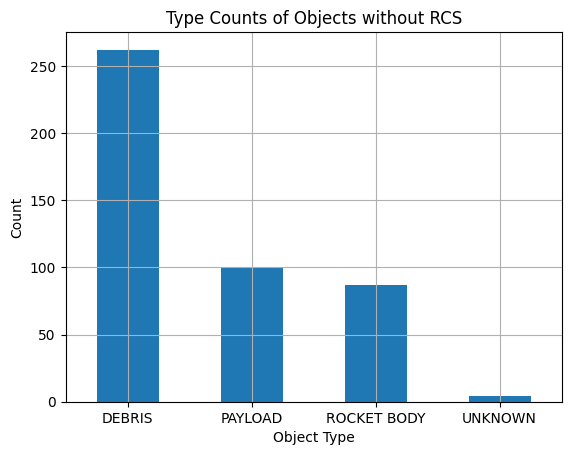

In [50]:

df_na_rcs_no_dup["TYPE"].value_counts().plot(kind='bar')

plt.title('Type Counts of Objects without RCS')
plt.xlabel('Object Type')
plt.ylabel('Count')
plt.xticks(rotation=0)  

plt.grid()

3. about 22K states aren't labeled as DB, RB, or Payload (around 2% of our total state data), but these states belong to only 453 objects. 

These are strange. All of them have the name OBJECT {Alphbetical Letter}. Most belong to China or are labeled as "TBD." Some of TBD objects were strangely NOT in the Union of Concerned Scientists Database but were in N2YO (I only cross-referenced a few). The purpose of objects are likely in part classified for different reasons. Because we can't obtain more information about them, we should drop them, since having a  4th "unknown" category to our response variable is undesirable. 


TODO: type of missingness; MNAR? 



0


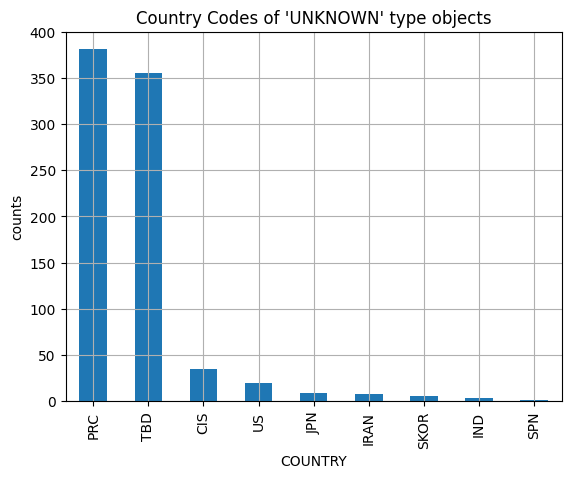

In [51]:
df_unknown = df[df['TYPE']=="UNKNOWN"]
df_unknown_no_dup = df_unknown.drop_duplicates(subset='NUMBER', keep='first')


print(df_unknown_no_dup[~df_unknown_no_dup["NAME"].str.contains('OBJECT')].shape[0]) # checks to see if all of them have "OBJECT" in their name

df_unknown_no_dup.value_counts("COUNTRY").plot(kind='bar')
plt.grid()
plt.title("Country Codes of 'UNKNOWN' type objects")
plt.ylabel('counts');

### Data Imbalance 

<i>
Instructions (Delete This): 


Imbalanced data is a common issue in classification problems when one class has significantly fewer samples than the other. When dealing with imbalanced data, machine learning models may learn to favor the majority class and make predictions that prioritize accuracy for that class. This can result in unsatisfactory performance for the minority class and reduced overall model effectiveness.Assess the class distribution in your dataset, especially for classification tasks. If a significant imbalance is present, consider resampling techniques (oversampling minorities or undersampling majorities) or applying synthetic data generation methods like SMOTE to achieve a balanced dataset, another CS1090a content piece.
</i>

1. Most state data is for is payloads 


TODO: is this consistent across regime? 

In [10]:
# 

is RCS/size missingness consistent across regimes? 

2. Most of our states are LEO regimes

In [11]:
df['REGIME'].value_counts()

REGIME
LEO    888350
GEO     71310
HEO     63506
MEO     10843
Name: count, dtype: int64

### Feature Scaling:


<i>
Instructions (Delete This)

Scaling the data is a crucial step in improving model performance and avoiding bias, as well as enhancing interpretability. When features are not appropriately scaled, those with larger scales can potentially dominate the analysis and result in biased conclusions. Standardize or normalize numerical features to ensure equal weighting in analytical models. Choose the most appropriate scaling method (e.g., Min-Max normalization, Z-score standardization) based on your data distribution and the models you plan to use.
</i>


1. should scale features 

2. should hot encode categorical variables 